**21bai1919 Jasti Karthikeya**


Under the smart city project, the Chennai Corporation aims to enhance traffic discipline by leveraging CCTV cameras installed at traffic signals. With the city facing congestion and numerous traffic offenses daily, the traffic police possess image and video databases to monitor and enforce traffic regulations. To assist the traffic police in their efforts, a deep learning model tailored for traffic offense detection should be designed and implemented. Design a yolo deep learning model that will detect only the vehicles type objects which assists the police

In [ ]:
!pip install -q --upgrade keras-cv
!pip install -q --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 31.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [ ]:
import os

os.environ["KERAS_BACKEND"] = "jax" #@param ["tensorflow", "jax", "torch"]
from tensorflow import data as tf_data
import tensorflow_datasets as tfds
import keras
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
from keras_cv import visualization
import tqdm

In [ ]:
pretrained_model = keras_cv.models.YOLOV8Detector.from_preset(
    "yolo_v8_m_pascalvoc", bounding_box_format="xywh"
)


pretrained_model.summary()

100%|██████████| 2.27k/2.27k [00:00<00:00, 3.95MB/s]
100%|██████████| 99.5M/99.5M [00:01<00:00, 86.2MB/s]


Model: "yolov8_detector"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, None, None, 3)  │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ functional_1 (Functional) │ [(None, None, None,    │     11,872,464 │ input_layer_1[0][0]    │
│                           │ 192), (None, None,     │                │                        │
│                           │ None, 384), (None,     │                │                        │
│                           │ None, None, 576)]      │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat (Repeat)           │ (None, None, None,     │              0 │ functional_1[0][2]     │
│                           │ 576)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ repeat_1 (Repeat)         │ (None, None, None,     │              0 │ repeat[0][0]           │
│                           │ 576)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_5             │ (None, None, None,     │              0 │ repeat_1[0][0],        │
│ (Concatenate)             │ 960)                   │                │ functional_1[0][1]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_conv      │ (None, None, None,     │        368,640 │ concatenate_5[0][0]    │
│ (Conv2D)                  │ 384)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_bn        │ (None, None, None,     │          1,536 │ pa_fpn_p4p5_pre_conv[… │
│ (BatchNormalization)      │ 384)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre           │ (None, None, None,     │              0 │ pa_fpn_p4p5_pre_bn[0]… │
│ (Activation)              │ 384)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ split_4 (Split)           │ [(None, None, None,    │              0 │ pa_fpn_p4p5_pre[0][0]  │
│                           │ 192), (None, None,     │                │                        │
│                           │ None, 192)]            │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_pad   │ (None, None, None,     │              0 │ split_4[0][1]          │
│ (ZeroPadding2D)           │ 192)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_conv  │ (None, None, None,     │        331,776 │ pa_fpn_p4p5_pre_0_1_p… │
│ (Conv2D)                  │ 192)                   │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pa_fpn_p4p5_pre_0_1_bn    │ (None, None, None,     │            768 │ pa_fpn_p4p5_pre_0_1_c… │
│ (BatchNormalization)      │ 192)                   │                │                        │
├──────────────────────

 Total params: 25,901,004 (98.80 MB)

 Trainable params: 25,867,884 (98.68 MB)

 Non-trainable params: 33,120 (129.38 KB)

In [ ]:
class_ids = [
    "Aeroplane",
    "Bicycle",
    "Bird",
    "Boat",
    "Bottle",
    "Bus",
    "Car",
    "Cat",
    "Chair",
    "Cow",
    "Dining Table",
    "Dog",
    "Horse",
    "Motorbike",
    "Person",
    "Potted Plant",
    "Sheep",
    "Sofa",
    "Train",
    "Tvmonitor",
    "Total",
]
class_mapping = dict(zip(range(len(class_ids)), class_ids))

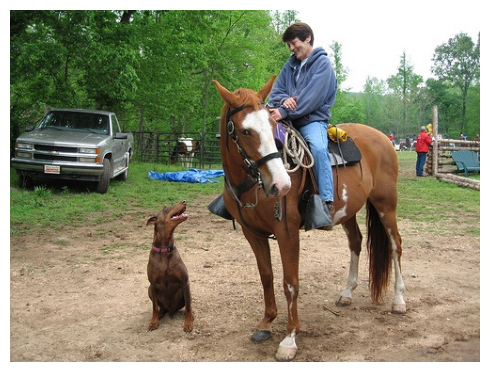

In [ ]:
image2 = keras.utils.load_img('/content/Horse.jpg')


visualization.plot_image_gallery(
    np.array([image2]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)


image_batch = inference_resizing([image2])

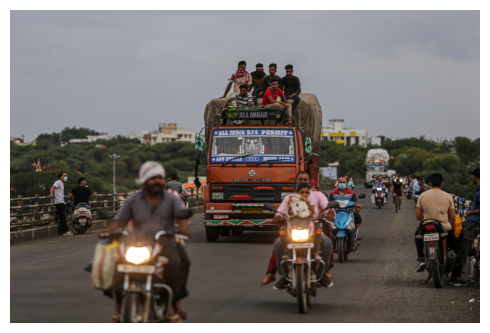

In [ ]:
image2 = keras.utils.load_img('/content/-1x-1.jpg')


visualization.plot_image_gallery(
    np.array([image2]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)


image_batch = inference_resizing([image2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


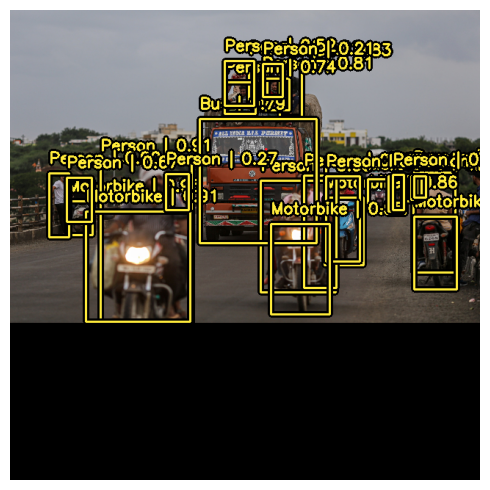

In [ ]:
y_pred = pretrained_model.predict(image_batch)

visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)
image = np.array(image2)

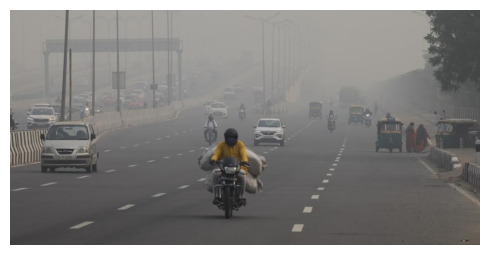

In [ ]:
image2 = keras.utils.load_img('/content/IMG111.jpg')


visualization.plot_image_gallery(
    np.array([image2]),
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5,
)

inference_resizing = keras_cv.layers.Resizing(
    640, 640, pad_to_aspect_ratio=True, bounding_box_format="xywh"
)


image_batch = inference_resizing([image2])

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


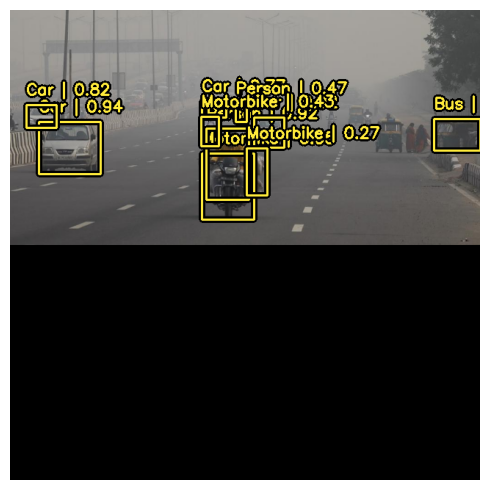

In [ ]:
y_pred = pretrained_model.predict(image_batch)

visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format="xywh",
    class_mapping=class_mapping,
)
image = np.array(image2)

In [ ]:
print("END")

END
